# Ion Temperature Gradient Drift Dispersion (Kappa Distribution)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plasmapy
from scipy import special as sp
import scipy.optimize as op
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.colors as colors
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
mi2me = 1836
ve2vi = 150
L_t2rho_i = 10
wp_i2wc_i = 100

kappa_e = 3
kappa_i = 3
fke = np.sqrt(kappa_e/(kappa_e-0.5))
fki = np.sqrt(kappa_i/(kappa_i-0.5))

print('Te/Ti')
print('M',ve2vi**2/mi2me)
print('MK',ve2vi**2/mi2me*(kappa_i-3/2)/kappa_i)
print('KK',ve2vi**2/mi2me*(kappa_i-3/2)/(kappa_e-3/2)*kappa_e/kappa_i)

Te/Ti
M 12.254901960784315
MK 6.127450980392157
KK 12.254901960784315


In [4]:
terms = 300 # number of terms for the integration
gl_1 = sp.roots_genlaguerre(terms,kappa_i-0.5)
gl_2 = sp.roots_genlaguerre(terms,kappa_i-1.5)
gl_e = sp.roots_genlaguerre(terms,kappa_e-0.5)

def PDRM(w2wc,ky_rho_i,kz_rho_i,eta_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    L_n2rho_i = eta_i*L_t2rho_i
    zeta_ni = ky2kz/L_n2rho_i/np.sqrt(2)
    zeta_ti = ky2kz/L_t2rho_i/np.sqrt(2)
    zeta_ne = -zeta_ni*ve2vi/mi2me
    g0 = sp.ive(0,ky_rho_i**2)
    g1 = sp.ive(1,ky_rho_i**2)
    
    re = 1 + (zeta_e-zeta_ne)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)

    ri1 = (zeta_i-zeta_ni+0.5*zeta_ti)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*g0
    
    ri2 = zeta_ti*(0.5*zeta_i*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i)*g0-plasmapy.dispersion.plasma_dispersion_func(zeta_i)*ky_rho_i**2*(g1-g0))

    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2
    return [r.real,r.imag]

def PDRMK(w2wc,ky_rho_i,kz_rho_i,eta_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    L_n2rho_i = eta_i*L_t2rho_i
    zeta_ni = 1.0/np.sqrt(2)*ky2kz/L_n2rho_i*kappa_i/(kappa_i-1.5)
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)
    zeta_ne = -zeta_ni*ve2vi/mi2me*(kappa_i-1.5)/kappa_i

    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)

    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    ri1 =  np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 =  np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    re = 1 + (zeta_e-zeta_ne)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)
    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

def PDRKM(w2wc,ky_rho_i,kz_rho_i,eta_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)*fke
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    L_n2rho_i = eta_i*L_t2rho_i
    zeta_ni = 1.0/np.sqrt(2)*ky2kz/L_n2rho_i
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i
    zeta_ne = -zeta_ni*ve2vi/mi2me*kappa_e/(kappa_e-1.5)

    g0 = sp.ive(0,ky_rho_i**2)
    g1 = sp.ive(1,ky_rho_i**2)

    Ke_integrad = lambda be: np.sqrt(be) * (zeta_e-zeta_ne*(kappa_e-3/2)/kappa_e/be) * plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*sp.ive(0,ky_rho_e**2/be)

    re = 1.0 + np.dot(gl_e[1],Ke_integrad(gl_e[0]/kappa_e))/sp.gamma(kappa_e+0.5)

    ri1 = (zeta_i-zeta_ni+0.5*zeta_ti)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*g0

    ri2 = zeta_ti*(0.5*zeta_i*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i)*g0-plasmapy.dispersion.plasma_dispersion_func(zeta_i)*ky_rho_i**2*(g1-g0))

    ri = 1.0 + ri1 + ri2

    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

def PDRK(w2wc,ky_rho_i,kz_rho_i,eta_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki*fke
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    L_n2rho_i = eta_i*L_t2rho_i
    zeta_ni = 1.0/np.sqrt(2)*ky2kz/L_n2rho_i*kappa_i/(kappa_i-1.5)
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)
    zeta_ne = -zeta_ni*ve2vi/mi2me*kappa_e/(kappa_e-1.5)*(kappa_i-1.5)/kappa_i

    # Ke_integrad = lambda be: np.sqrt(be) * zeta_e * plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*sp.ive(0,ky_rho_e**2/be)
    Ke_integrad = lambda be: np.sqrt(be) * (zeta_e-zeta_ne*(kappa_e-3/2)/kappa_e/be) * plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*sp.ive(0,ky_rho_e**2/be)

    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)

    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    re =  1.0 + np.dot(gl_e[1],Ke_integrad(gl_e[0]/kappa_e))/sp.gamma(kappa_e+0.5)
    ri1 = np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 = np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

In [5]:
kz_s_pow = -4
kz_e_pow = -2
kz_s = 10**kz_s_pow
kz_e = 10**kz_e_pow

ky_s = 0.01
ky_e = 2.5

eta_s = 2.05
eta_e = 0.85

wguess_m = 2e-5
rguess_m = 5e-6
# wguess_m = 2e-7
# rguess_m = 5e-7

mth = 'hybr' # 'lm' 'hybr' 'exciting' root finding method
L_n2rho_i = eta_s*L_t2rho_i
sM=op.root(lambda w:PDRM(w,ky_s,kz_s,eta_s),[wguess_m,rguess_m],method=mth)
sMK=op.root(lambda w:PDRMK(w,ky_s,kz_s,eta_s),[wguess_m,rguess_m],method=mth)
sK=op.root(lambda w:PDRK(w,ky_s,kz_s,eta_s),[wguess_m,rguess_m],method=mth)
print('M',sM.success)
print(sM.x[0],sM.x[1])
print('MK',sMK.success)
print(sMK.x[0],sMK.x[1])
print('K',sK.success)
print(sK.x[0],sK.x[1])

M True
2.2207907524389777e-05 3.4840038370964384e-06
MK True
2.2699235708931896e-05 3.68813881977721e-06
K True
2.23168088829081e-05 3.6647064402326845e-06


In [6]:
kz_rho_i_list = np.logspace(kz_s_pow,kz_e_pow,num=120,base=10)
ky_rho_i_list = np.linspace(ky_s,ky_e,num=250,endpoint=True)
eta_i_list = np.linspace(eta_s,eta_e,num=150)

- Solve $\omega_R$ and $\gamma$ at initial $k_y$ and $k_z$ for varying $\eta_i$

In [7]:
wgm_eta_kykz0 = []
rgm_eta_kykz0 = []
wgm = wguess_m
rgm = rguess_m

wgmk_eta_kykz0 = []
rgmk_eta_kykz0 = []
wgmk = wguess_m
rgmk = rguess_m

wgk_eta_kykz0 = []
rgk_eta_kykz0 = []
wgk = wguess_m
rgk = rguess_m

for eta_i_each in tqdm(eta_i_list):
    sM=op.root(lambda w:PDRM(w,ky_s,kz_s,eta_i_each),[wgm,rgm],method=mth)
    if sM.success:
        wgm = sM.x[0]*0.5
        rgm = sM.x[1]*0.9
        wgm_eta_kykz0.append(sM.x[0])
        rgm_eta_kykz0.append(sM.x[1])

    sMK=op.root(lambda w:PDRMK(w,ky_s,kz_s,eta_i_each),[wgmk,rgmk],method=mth)
    if sMK.success:
        wgmk = sMK.x[0]*0.5
        rgmk = sMK.x[1]*0.9
        wgmk_eta_kykz0.append(sMK.x[0])
        rgmk_eta_kykz0.append(sMK.x[1])

    sK=op.root(lambda w:PDRK(w,ky_s,kz_s,eta_i_each),[wgk,rgk],method=mth)
    if sK.success:
        wgk = sK.x[0]*0.5
        rgk = sK.x[1]*0.9
        wgk_eta_kykz0.append(sK.x[0])
        rgk_eta_kykz0.append(sK.x[1])

print(len(wgm_eta_kykz0),len(wgmk_eta_kykz0),len(wgk_eta_kykz0))

100%|██████████| 150/150 [00:00<00:00, 162.95it/s]

150 150 150


In [8]:
def SolveM(idx):
    r_M_list_max = []
    wgm = wgm_eta_kykz0[idx]
    rgm = rgm_eta_kykz0[idx]
    eta_i_each = eta_i_list[idx]

    for ky in ky_rho_i_list:
        w_M_list = []
        r_M_list = []

        for kz in kz_rho_i_list:
            sM=op.root(lambda w:PDRM(w,ky,kz,eta_i_each),[wgm,rgm],method=mth)
            if sM.success:
                wgm = sM.x[0]*0.7
                rgm = sM.x[1]*0.6
                w_M_list.append(sM.x[0])
                r_M_list.append(sM.x[1])
            
        r_M_list_max.append(np.max(r_M_list))
        wgm = w_M_list[0]*0.6
        rgm = r_M_list[0]*0.6

    return r_M_list_max

def SolveMK(idx):
    r_MK_list_max = []
    wgmk = wgmk_eta_kykz0[idx]
    rgmk = rgmk_eta_kykz0[idx]
    eta_i_each = eta_i_list[idx]

    for ky in ky_rho_i_list:
        w_MK_list = []
        r_MK_list = []

        for kz in kz_rho_i_list:
            sMK=op.root(lambda w:PDRMK(w,ky,kz,eta_i_each),[wgmk,rgmk],method=mth)
            if sMK.success:
                wgmk = sMK.x[0]*0.7
                rgmk = sMK.x[1]*0.6
                w_MK_list.append(sMK.x[0])
                r_MK_list.append(sMK.x[1])
            
        r_MK_list_max.append(np.max(r_MK_list))
        wgmk = w_MK_list[0]*0.6
        rgmk = r_MK_list[0]*0.6

    return r_MK_list_max

def SolveK(idx):
    r_K_list_max = []
    wgk = wgk_eta_kykz0[idx]
    rgk = rgk_eta_kykz0[idx]
    eta_i_each = eta_i_list[idx]

    for ky in ky_rho_i_list:
        w_K_list = []
        r_K_list = []

        for kz in kz_rho_i_list:
            sK=op.root(lambda w:PDRK(w,ky,kz,eta_i_each),[wgk,rgk],method=mth)
            if sK.success:
                wgk = sK.x[0]*0.7
                rgk = sK.x[1]*0.6
                w_K_list.append(sK.x[0])
                r_K_list.append(sK.x[1])
            
        r_K_list_max.append(np.max(r_K_list))
        wgk = w_K_list[0]*0.6
        rgk = r_K_list[0]*0.6

    return r_K_list_max

In [9]:
r_M_mat_max = Parallel(n_jobs=-1,verbose=8)(delayed(SolveM)(i) for i in range(len(eta_i_list)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 130 out of 150 | elapsed:  5.2min remaining:   48.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.7min finished


In [10]:
r_MK_mat_max = Parallel(n_jobs=-1,verbose=8)(delayed(SolveMK)(i) for i in range(len(eta_i_list)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 130 out of 150 | elapsed: 29.5min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 32.6min finished


In [11]:
r_K_mat_max = Parallel(n_jobs=-1,verbose=8)(delayed(SolveK)(i) for i in range(len(eta_i_list)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 130 out of 150 | elapsed: 35.3min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 38.6min finished


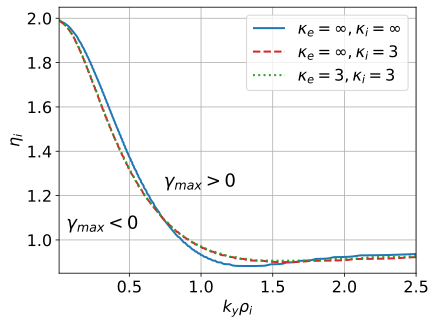

In [13]:
KY,EI = np.meshgrid(ky_rho_i_list,eta_i_list)
C_M = plt.contour(KY,EI,r_M_mat_max,levels=[0.0],colors='tab:blue',linestyles='-')
C_MK= plt.contour(KY,EI,r_MK_mat_max,levels=[0.0],colors='tab:red',linestyles='--')
C_K = plt.contour(KY,EI,r_K_mat_max,levels=[0.0],colors='tab:green',linestyles=':')
plt.text(0.06,1.05,r'$\gamma_{max}<0$',fontsize=18)
plt.text(0.74,1.24,r'$\gamma_{max}>0$',fontsize=18)
plt.xlabel(r'$k_y\rho_i$')
plt.ylabel(r'$\eta_i$')
plt.grid()

lM,_ = C_M.legend_elements()
lMK,_= C_MK.legend_elements()
lK,_ = C_K.legend_elements()
plt.legend([lM[0], lMK[0],lK[0]], ['$\kappa_e=\infty,\kappa_i=\infty$','$\kappa_e=\infty,\kappa_i=3$','$\kappa_e=3,\kappa_i=3$'])
# plt.savefig('./fig6_IDTG_boundary.pdf', bbox_inches='tight')
plt.show()